In [1]:
#import 
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.primitives import StatevectorSampler

# MPS
#from qiskit import QuantumCircuit, transpile
#from qiskit_aer import AerSimulator

#math
import numpy as np
import matplotlib.pyplot as plt

#from qiskit.quantum_info import SparsePauliOp
#from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

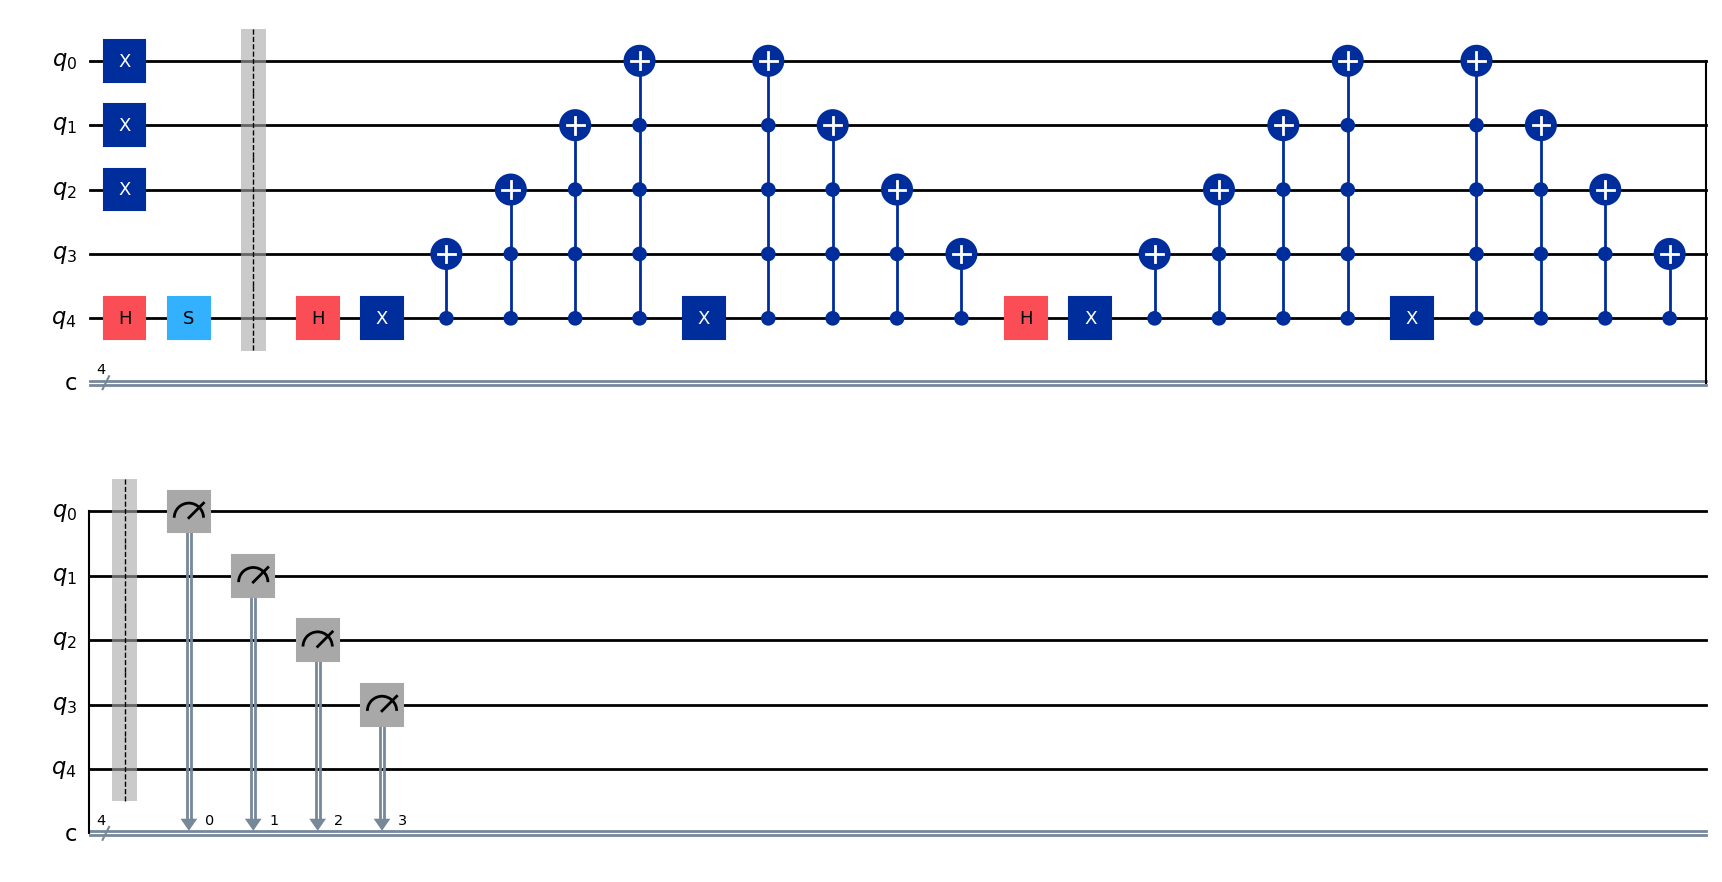

In [2]:
#--- Parameters
numBitPosition = 4 # qubit for positions
numBitCoin     = 1 # qubit for states

#--- init
qc = QuantumCircuit(numBitPosition + numBitCoin, numBitPosition)

#--- 
qc.x(0)
qc.x(1)
qc.x(2)

#---
qc.h(numBitPosition)
qc.s(numBitPosition)
qc.barrier()
qc.draw("mpl")

# steps for QW
qwStep = 2
#---
for i in range(qwStep):
    #---coin
    qc.h(4)
    #---shift <adder>
    qc.x(4)
    qc.cx(4,3)
    qc.ccx(4,3,2)
    qc.mcx([4,3,2],1)
    qc.mcx([4,3,2,1],0)
    #---shift <subtractor>
    qc.x(4)
    qc.mcx([4,3,2,1],0)
    qc.mcx([4,3,2],1)
    qc.ccx(4,3,2)
    qc.cx(4,3)
#---measure
qc.barrier()
qc.measure([0,1,2,3],[0,1,2,3])
qc.draw("mpl")

In [3]:
shots = 1200
sampler = StatevectorSampler()
result = sampler.run([qc],shots=shots).result()

# Access result data for PUB 0
data_pub = result[0].data

# Access bitstring for the classical register "meas"
bitstrings = data_pub.c.get_bitstrings()
print(f"The number of bitstrings is: {len(bitstrings)}")

# Get counts for the classical register "meas"
counts = data_pub.c.get_counts()
print(f"The counts are: {counts}")

The number of bitstrings is: 1200
The counts are: {'0111': 642, '0000': 270, '0011': 288}


In [4]:
# fill with count 0
def decimal_to_base(n, base):
    return format(n, f'{base}')
bitBase = numBitPosition
base = f'0{bitBase}b'

for i in range(numBitPosition ** 2):
    binary_number = decimal_to_base(i, base)
    if binary_number not in counts:
        #uprint(binary_number)
        counts[binary_number] = 0

# print(f"The counts are: {counts}")

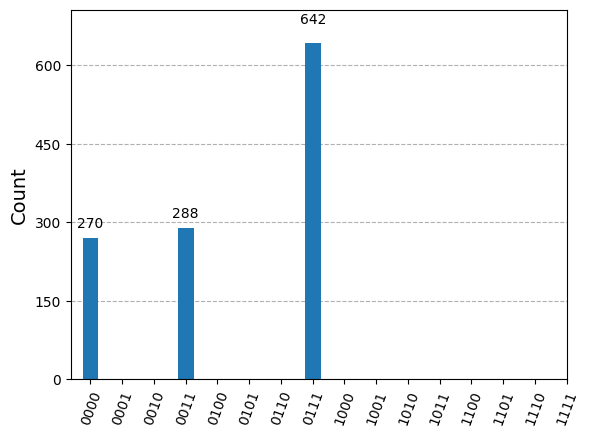

In [5]:
plot_histogram(counts)

In [6]:
import qiskit
qiskit.__version__

'1.1.0'